In [1]:
# Packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Import Data
data = pd.read_csv("titanic.csv")

## Cleaning Data

In [2]:
# Drop Irrelevant Fields
data.drop(["PassengerId", "Name", "SibSp", "Parch", "Ticket", "Cabin"], axis=1, inplace=True)

In [3]:
# Check Null Values
for column in data:
    print(str(column))
    print(data[column].isnull().value_counts())

Survived
False    891
Name: Survived, dtype: int64
Pclass
False    891
Name: Pclass, dtype: int64
Sex
False    891
Name: Sex, dtype: int64
Age
False    714
True     177
Name: Age, dtype: int64
Fare
False    891
Name: Fare, dtype: int64
Embarked
False    889
True       2
Name: Embarked, dtype: int64


In [4]:
# Remove Null Values
data = data[data["Age"].isnull() != True]
data = data[data["Embarked"].isnull() != True]

In [5]:
# Encode Sex and Embarked
data.loc[data["Embarked"] == "S", "Embarked"] = 0
data.loc[data["Embarked"] == "C", "Embarked"] = 1
data.loc[data["Embarked"] == "Q", "Embarked"] = 2

data.loc[data["Sex"] == "male", "Sex"] = 0
data.loc[data["Sex"] == "female", "Sex"] = 1

In [6]:
data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked
0,0,3,0,22.0,7.2500,0
1,1,1,1,38.0,71.2833,1
2,1,3,1,26.0,7.9250,0
3,1,1,1,35.0,53.1000,0
4,0,3,0,35.0,8.0500,0


## Create Training and Test Data Sets

In [7]:
X = data.iloc[:,1:].values.reshape(-1,5)
y = data.iloc[:,0].values

r = 3
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.2,random_state=r)
X_train,X_dev,y_train,y_dev = train_test_split(X_train,y_train,train_size=0.3,random_state=r)

## Fitting and Accuracy Testing Models

In [8]:
# Base Tree
tree_model = DecisionTreeClassifier(max_depth=None, random_state=r)
tree_model.fit(X_train,y_train)
tree_pred = tree_model.predict(X_test)
tree_acc = accuracy_score(y_test, tree_pred)
print(f"The accuracy for the basic tree is: {tree_acc}")

The accuracy for the basic tree is: 0.6280701754385964


In [9]:
# Bagged Model
bag_model = BaggingClassifier(base_estimator=tree_model,n_estimators=100,random_state=r)
bag_model.fit(X_train,y_train)
bag_pred = bag_model.predict(X_test)
bag_acc = accuracy_score(y_test,bag_pred)
print(f"The accuracy for the bagged model is: {bag_acc}")

The accuracy for the bagged model is: 0.6947368421052632


In [10]:
# Random Forest Model
rand_model = RandomForestClassifier(random_state=r)
rand_model.fit(X_train,y_train)
rand_pred = rand_model.predict(X_test)
rand_acc = accuracy_score(y_test,rand_pred)
print(f"The accuracy for the random forest model is: {rand_acc}")

The accuracy for the random forest model is: 0.7087719298245614


In [11]:
# Boosted Model
bst_model = AdaBoostClassifier(base_estimator=tree_model,n_estimators=100,random_state=r)
bst_model.fit(X_train,y_train)
bst_pred = bst_model.predict(X_test)
bst_acc = accuracy_score(y_test,bst_pred)
print(f"The accuracy for the boosted model is: {bst_acc}")

The accuracy for the boosted model is: 0.5912280701754385


## Assessing Forest Model

In [12]:
# Forest Features
forest_features = pd.Series(rand_model.feature_importances_).sort_values(ascending=False)
print(forest_features)

3    0.352627
2    0.335902
0    0.156835
1    0.093923
4    0.060713
dtype: float64


According the the above feature importance scores, the most important feature in determining passenger survival is feature 3, which (assuming these refer to the respective fields) is "Fare".

## Developing Boosted Model


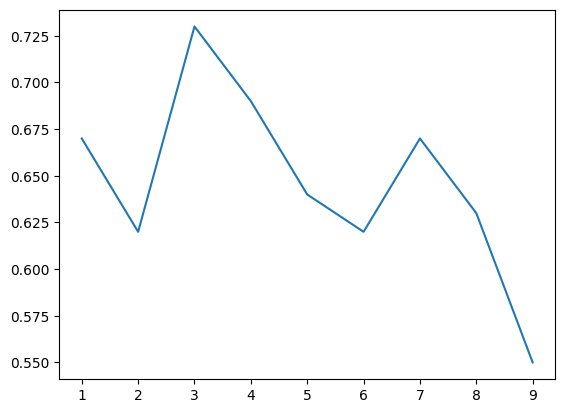

In [13]:
# Tune Max_Depth
depths = list(range(1,10))
scores = []
for depth in depths:
    test_model = DecisionTreeClassifier(max_depth=depth, random_state=r)
    test_model.fit(X_train,y_train)
    test_pred = test_model.predict(X_dev)
    test_acc = accuracy_score(y_dev,test_pred)
    scores.append(test_acc)

plt.plot(depths,scores)

As can be seen, the accuracy peaks significantly at a depth of three, so this will become our depth

In [14]:
# Fit to tailored Depth
tailored_model = DecisionTreeClassifier(max_depth=3, random_state=r)
tailored_model.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3, random_state=3)

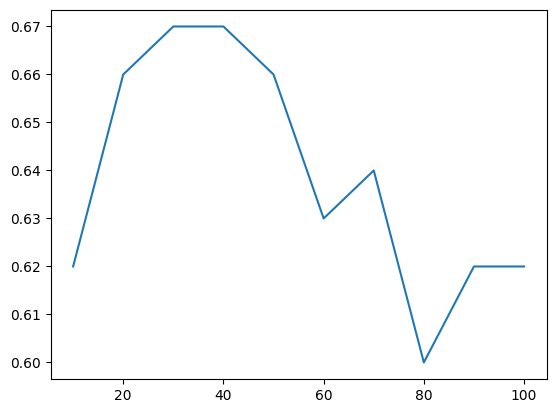

In [15]:
# Tune Estimator Numbers
estimators = list(range(10,101,10))
est_scores = []

for est in estimators:
    test_model = AdaBoostClassifier(base_estimator=tailored_model,n_estimators=est,random_state=r)
    test_model.fit(X_train,y_train)
    test_pred = test_model.predict(X_dev)
    test_acc = accuracy_score(y_dev,test_pred)
    est_scores.append(test_acc)

plt.plot(estimators,est_scores)

The model seems to peak in accuracy around 30 estimators, so I will set this as the model default.

In [16]:
# Final Boosted Model + Accuracy Test
final_model = AdaBoostClassifier(base_estimator=tailored_model,n_estimators=30,random_state=r)
final_model.fit(X_train,y_train)
final_pred = final_model.predict(X_test)
final_acc = accuracy_score(y_test,final_pred)

print(f"The accuracy score for the final model is: {final_acc}")

The accuracy score for the final model is: 0.7


## Accuracy Scores and Observations

In [17]:
# Prints Accuracy Scores for all models

print(f"""Scores for models:
Basic Tree: {tree_acc}
Bagged: {bag_acc}
Random Forest: {rand_acc}
Boosted (Untuned): {bst_acc}
Boosted (Tuned): {final_acc}""")

Scores for models:
Basic Tree: 0.6280701754385964
Bagged: 0.6947368421052632
Random Forest: 0.7087719298245614
Boosted (Untuned): 0.5912280701754385
Boosted (Tuned): 0.7


Higest Accuracy: Random Forest Model

Tunings for Boosted (Tuned): Max Depth =  3, Estimators = 30

#### Observations:
There are three main observations to be made here:

- The untuned boosted model is actually less accurate than the basic tree, making it the least accurate model overall.
- The tuned version of the boosted model is far more accurate than the original, being the second most accurate model compared to the originals bottom performance. The overall accuracy score was improved by over 10%!
- The accuracy scores seem to be grouped into two groups, the untuned boosted and basic tree being around 60% accurate, and the rest all hovering around 70%.